In [2]:
%cd ..

/home/coder/project


In [3]:
import torch
from torch import nn

## Dataset loading

In [4]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import QM9

from torch_geometric.transforms import Compose, NormalizeScale, NormalizeFeatures


# Load the QM9 dataset and filter graphs with less than 8 nodes
dataset = QM9(root='data/QM9', transform=Compose([NormalizeScale()]))
filtered_dataset = []
max_nodes = 9
for data in dataset:
    if data.num_nodes < max_nodes:
        data.x = data.x[:, :5] # keep only the atomic type
        filtered_dataset.append(data)


In [5]:
# normalize y values scale

y_values = torch.cat([data.y for data in filtered_dataset], dim=0)

a, b = y_values.min(dim=0)[0], y_values.max(dim=0)[0]
mean = (a + b)/2
std = (b - a)/2
for data in filtered_dataset:
    data.y = (data.y - mean)/std

In [7]:
criterion = nn.MSELoss()

## Load pretrained models

In [21]:
models = []
labels = []     # Q/C, number of params, wandb id, something special

In [22]:
# final stage
import pennylane as qml
import pennylane.numpy as np
from typing import Literal
import torch
import torch.nn as nn
import torch.nn.functional as F

def encoding_layer(values):
    """
    pooling layer, that encodes params, or edge features in nodes

    values: [num nodes] tensor
    """
    for w in range(values.shape[0]):
        qml.RX(values[w], w)

def edged_entengling_layer(edge_index, rot_param):
    for i in range(edge_index.shape[1]):
        qml.IsingYY(rot_param, wires=[edge_index[0,i], edge_index[1,i]])

def measurement(n_qubits):
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def parametrised_rotations(angles, wires):
    for w in wires:
        qml.Rot(*angles, w)
    

n_layers = 3
def circuit(inputs, params, edge_weights, atoms_weight: list[5]):
    data = inputs
    num_atoms = data.x.shape[0]
    atom_embeddings = data.x @ atoms_weight   # [num_atoms, 5] * [5] -> [num_atoms]
    # assert atom_embeddings.shape == (1,)
    edge_index = data.edge_index
    for l in range(n_layers):
        encoding_layer(atom_embeddings)
        parametrised_rotations(params[2*l], wires=range(num_atoms))
        edged_entengling_layer(edge_index, edge_weights[l])
        parametrised_rotations(params[2*l+1], wires=range(num_atoms))
    return measurement(num_atoms)

class QuantumGNNv1(nn.Module):
    def init_weight(self, weights_shape):
        weights = {}
        for name, shape in weights_shape.items():
            t = torch.nn.Parameter(torch.rand(*shape, requires_grad=True).float()*2*np.pi, requires_grad=True)
            self.register_parameter(name, t)
            weights[name] = t
        return weights
    def __init__(self, readout: Literal["global", "local"], max_qubits: int):
        super().__init__()
        device = qml.device("lightning.qubit", wires=max_qubits)
        self.qnode = qml.QNode(circuit, device)
        weights_shape = {"params": [2*n_layers, 3], "edge_weights":[n_layers], "atoms_weight": [5]}

        self.qnode_weights = self.init_weight(weights_shape)
        
        self.qlayer = qml.qnn.TorchLayer(self.qnode, weights_shape)

    def forward(self, batch):
        # print(batch)
        results = []
        for i in range(len(batch)):
            g = batch[i]
            # print(g)
            exps = self.qnode(g, **self.qnode_weights)
            exps = torch.stack(exps).float()
            # print(exps)
            # assert exps.shape == (g.num_atoms
            avgs = torch.mean(exps, axis=0, keepdim=True)
            results.append(avgs)
        x = torch.stack(results)    
        return x

model = QuantumGNNv1('global', max_nodes)

model.load_state_dict(torch.load("./logs/checkpoints1_id=11-12/qgnn_model_272.pth"))
models.append(model)
labels.append("Q model, 26 params, id=11-12")

In [23]:
import pennylane as qml
import pennylane.numpy as np
from typing import Literal
import torch
import torch.nn as nn
import torch.nn.functional as F

def encoding_layer(values):
    """
    pooling layer, that encodes params, or edge features in nodes

    values: [num nodes] tensor
    """
    for w in range(values.shape[0]):
        qml.RX(values[w], w)

def edged_entengling_layer(edge_index, rot_param):
    for i in range(edge_index.shape[1]):
        qml.IsingYY(rot_param, wires=[edge_index[0,i], edge_index[1,i]])

def measurement(n_qubits):
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def parametrised_rotations(angles, wires):
    for w in wires:
        qml.Rot(*angles, w)
    

n_layers = 3
def circuit(inputs, params, edge_weights, atoms_weight: list[5]):
    data = inputs
    num_atoms = data.x.shape[0]
    atom_embeddings = data.x @ atoms_weight   # [num_atoms, 5] * [5] -> [num_atoms]
    # assert atom_embeddings.shape == (1,)
    edge_index = data.edge_index
    for l in range(n_layers):
        encoding_layer(atom_embeddings)
        parametrised_rotations(params[2*l], wires=range(num_atoms))
        edged_entengling_layer(edge_index, edge_weights[l])
        parametrised_rotations(params[2*l+1], wires=range(num_atoms))
    return measurement(num_atoms)

class QuantumGNNv2(nn.Module):
    def init_weight(self, weights_shape):
        weights = {}
        for name, shape in weights_shape.items():
            t = torch.nn.Parameter(torch.rand(*shape, requires_grad=True).float()*2*np.pi, requires_grad=True)
            self.register_parameter(name, t)
            weights[name] = t
        return weights
    def __init__(self, readout: Literal["global", "local"], max_qubits: int):
        super().__init__()
        device = qml.device("lightning.qubit", wires=max_qubits)
        self.qnode = qml.QNode(circuit, device)
        weights_shape = {"params": [2*n_layers, 3], "edge_weights":[n_layers], "atoms_weight": [5]}

        self.qnode_weights = self.init_weight(weights_shape)
        
        self.qlayer = qml.qnn.TorchLayer(self.qnode, weights_shape)

        self.fc1 = nn.Linear(1, 2)
        self.fc2 = nn.Linear(2, 1)
    def forward(self, batch):
        # print(batch)
        results = []
        for i in range(len(batch)):
            g = batch[i]
            # print(g)
            exps = self.qnode(g, **self.qnode_weights)
            exps = torch.stack(exps).float()
            # print(exps)
            # assert exps.shape == (g.num_atoms
            avgs = torch.mean(exps, axis=0, keepdim=True)
            results.append(avgs)
        x = torch.stack(results)    
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = QuantumGNNv2('global', max_nodes)
model.load_state_dict(torch.load("./logs/checkpoints2_id=19-20/qgnn_model_272.pth"))
models.append(model)
labels.append("Q model, 33 params, id=19-20")

In [24]:
import pennylane as qml
import pennylane.numpy as np
from typing import Literal
import torch
import torch.nn as nn
import torch.nn.functional as F

def encoding_layer(values):
    """
    pooling layer, that encodes params, or edge features in nodes

    values: [num nodes] tensor
    """
    for w in range(values.shape[0]):
        qml.RX(values[w], w)

def edged_entengling_layer(edge_index, rot_param):
    for i in range(edge_index.shape[1]):
        qml.IsingYY(rot_param, wires=[edge_index[0,i], edge_index[1,i]])

def measurement(n_qubits):
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def parametrised_rotations(angles, wires):
    for w in wires:
        qml.Rot(*angles, w)
    

n_layers = 3
def circuit(inputs, params, edge_weights, atoms_weight: list[5]):
    data = inputs
    num_atoms = data.x.shape[0]
    atom_embeddings = data.x @ atoms_weight   # [num_atoms, 5] * [5] -> [num_atoms]
    # assert atom_embeddings.shape == (1,)
    edge_index = data.edge_index
    for l in range(n_layers):
        encoding_layer(atom_embeddings)
        parametrised_rotations(params[2*l], wires=range(num_atoms))
        edged_entengling_layer(edge_index, edge_weights[l])
        parametrised_rotations(params[2*l+1], wires=range(num_atoms))
    return measurement(num_atoms)

class QuantumGNNv2(nn.Module):
    def init_weight(self, weights_shape):
        weights = {}
        for name, shape in weights_shape.items():
            t = torch.nn.Parameter(torch.rand(*shape, requires_grad=True).float()*2*np.pi, requires_grad=True)
            self.register_parameter(name, t)
            weights[name] = t
        return weights
    def __init__(self, readout: Literal["global", "local"], max_qubits: int):
        super().__init__()
        device = qml.device("lightning.qubit", wires=max_qubits)
        self.qnode = qml.QNode(circuit, device)
        weights_shape = {"params": [2*n_layers, 3], "edge_weights":[n_layers], "atoms_weight": [5]}

        self.qnode_weights = self.init_weight(weights_shape)
        
        self.qlayer = qml.qnn.TorchLayer(self.qnode, weights_shape)

        self.fc1 = nn.Linear(1, 2)
        self.fc2 = nn.Linear(2, 1)
    def forward(self, batch):
        # print(batch)
        results = []
        for i in range(len(batch)):
            g = batch[i]
            # print(g)
            exps = self.qnode(g, **self.qnode_weights)
            exps = torch.stack(exps).float()
            # print(exps)
            # assert exps.shape == (g.num_atoms
            avgs = torch.mean(exps, axis=0, keepdim=True)
            results.append(avgs)
        x = torch.stack(results)    
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = QuantumGNNv2('global', max_nodes)
model.load_state_dict(torch.load("./logs/checkpoints3_id=22/qgnn_model_299.pth"))
models.append(model)
labels.append("Q model, 33 params, id=22, bs=64")

## Visualize predictions

In [27]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, feature_idx):
    predictions = []
    answers = []
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            output = model(data)
            predictions.append(output)
            answers.append(data.y[:, feature_idx:feature_idx+1])
    predictions = torch.cat(predictions)
    answers = torch.cat(answers)
    plt.plot(answers, predictions, "o")
    plt.xlabel("correct answer")
    plt.ylabel("prediction")
    mse = criterion(answers, predictions).item()
    print("MSL loss:", round(mse, 3))
    return predictions, answers

batch_size = 1
dataloader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

MSL loss: 0.277


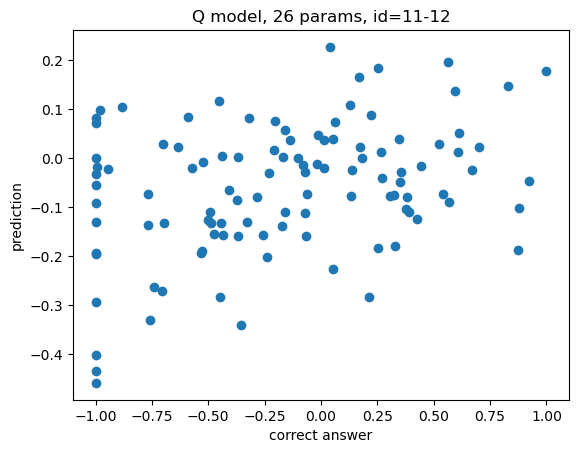

MSL loss: 0.267


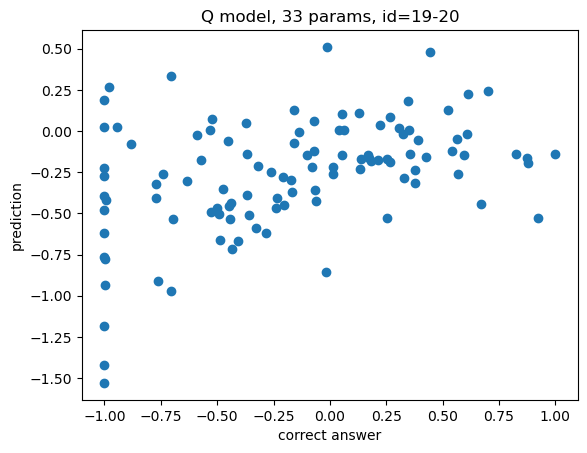

MSL loss: 0.297


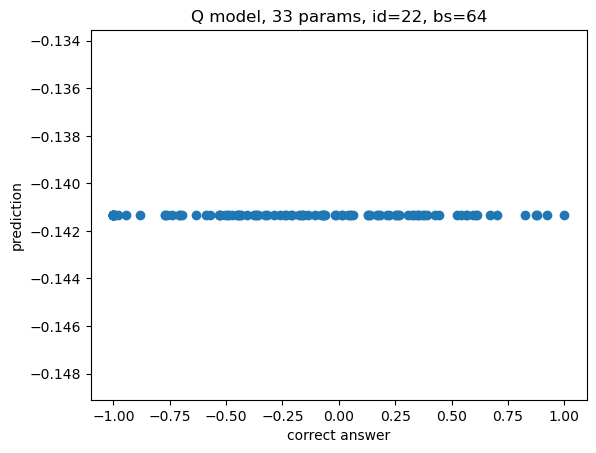

In [28]:
for model, label in zip(models, labels):
    predictions, answers  = visualize_predictions(model, dataloader, 0)
    plt.title(label)
    plt.show()
